# AutoML: Train "the best" Time-Series Forecasting model for the Energy Demand Dataset.

**Requirements** - In order to benefit from this tutorial, you will need:
- A basic understanding of Machine Learning
- An Azure account with an active subscription. [Create an account for free](https://azure.microsoft.com/free/?WT.mc_id=A261C142F)
- An Azure ML workspace. [Check this notebook for creating a workspace](../../../resources/workspace/workspace.ipynb) 
- A Compute Cluster. [Check this notebook to create a compute cluster](../../../resources/compute/compute.ipynb)
- A python environment
- Installed Azure Machine Learning Python SDK v2 - [install instructions](../../../README.md) - check the getting started section

**Learning Objectives** - By the end of this tutorial, you should be able to:
- Connect to your AML workspace from the Python SDK
- Create an `AutoML time-series forecasting Job` with the 'forecasting()' factory-fuction.
- Train the model using AmlCompute by submitting/running the AutoML forecasting training job
- Obtaing the model and score predictions with it

**Motivations** - This notebook explains how to setup and run an AutoML forecasting job. This is one of the nine ML-tasks supported by AutoML. Other ML-tasks are 'regression', 'classification', 'image classification', 'image object detection', 'nlp text classification', etc.

In this example we use the associated New York City energy demand dataset to showcase how you can use AutoML for a simple forecasting problem and explore the results. The goal is predict the energy demand for the next 48 hours based on historic time-series data.

# 1. Connect to Azure Machine Learning Workspace

The [workspace](https://docs.microsoft.com/en-us/azure/machine-learning/concept-workspace) is the top-level resource for Azure Machine Learning, providing a centralized place to work with all the artifacts you create when you use Azure Machine Learning. In this section we will connect to the workspace in which the job will be run.

## 1.1. Import the required libraries

In [27]:
# Import required libraries
from azure.identity import DefaultAzureCredential
from azure.ai.ml import MLClient

from azure.ai.ml.constants import AssetTypes
from azure.ai.ml import automl
from azure.ai.ml import Input

## 1.2. Configure workspace details and get a handle to the workspace

To connect to a workspace, we need identifier parameters - a subscription, resource group and workspace name. We will use these details in the `MLClient` from `azure.ai.ml` to get a handle to the required Azure Machine Learning workspace. We use the default [default azure authentication](https://docs.microsoft.com/en-us/python/api/azure-identity/azure.identity.defaultazurecredential?view=azure-python) for this tutorial. Check the [configuration notebook](../../configuration.ipynb) for more details on how to configure credentials and connect to a workspace.

In [28]:
credential = DefaultAzureCredential()
ml_client = None
try:
    ml_client = MLClient.from_config(credential)
except Exception as ex:
    print(ex)
    # Enter details of your AML workspace
    subscription_id = "<SUBSCRIPTION_ID>"
    resource_group = "<RESOURCE_GROUP>"
    workspace = "<AML_WORKSPACE_NAME>"

    ml_client = MLClient(credential, subscription_id, resource_group, workspace)

Found the config file in: C:\Users\nirovins\OneDrive - Microsoft\Documents\AzureML\config.json


### Show Azure ML Workspace information

In [29]:
import pandas as pd

workspace = ml_client.workspaces.get(name=ml_client.workspace_name)

output = {}
output["Workspace"] = ml_client.workspace_name
output["Subscription ID"] = ml_client.connections._subscription_id
output["Resource Group"] = workspace.resource_group
output["Location"] = workspace.location
pd.set_option("display.max_colwidth", None)
outputDf = pd.DataFrame(data=output, index=[""])
outputDf.T

,
Workspace,nirovins-southcentralus-ws
Subscription ID,381b38e9-9840-4719-a5a0-61d9585e1e91
Resource Group,nirovins-southcentralus-rg
Location,southcentralus


# 2. Data

We will use energy consumption [data from New York City](http://mis.nyiso.com/public/P-58Blist.htm) for model training. The data is stored in a tabular format and includes energy demand and basic weather data at an hourly frequency. 

With Azure Machine Learning MLTables you can keep a single copy of data in your storage, easily access data during model training, share data and collaborate with other users. 
Below, we will upload the data by creating an MLTable to be used for training.

**NOTE:** In this PRIVATE PREVIEW we're defining the MLTable in a separate folder and .YAML file.
In later versions, you'll be able to do it all in Python APIs.

In [30]:
# Training MLTable defined locally, with local data to be uploaded
my_training_data_input = Input(
    type=AssetTypes.MLTABLE, path="./data/training-mltable-folder"
)

We will upload the dirrectory with the test set so that further we will be able to run the inferencing on the batch endpoint.

In [31]:
import os
import shutil

os.makedirs("test_dataset", exist_ok=True)
shutil.copy(
    "data/test-mltable-folder/nyc_energy_test_clean.csv",
    "test_dataset/nyc_energy_test_clean.csv",
)

my_test_data_input = Input(
    type=AssetTypes.URI_FOLDER,
    path="test_dataset/",
)

In [32]:
my_training_data_input.__dict__

{'type': 'mltable',
 'name': None,
 'description': None,
 '_allowed_types': None,
 '_is_primitive_type': False,
 'path': './data/training-mltable-folder',
 'mode': None,
 'default': None,
 'optional': None,
 '_is_inferred_optional': False,
 'min': None,
 'max': None,
 'enum': None,
 'datastore': None}

# 3 Create or Attach existing AmlCompute.
[Azure Machine Learning Compute](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-set-up-training-targets#amlcompute) is a managed-compute infrastructure that allows the user to easily create a single or multi-node compute. In this tutorial, you create AmlCompute as your training compute resource.

#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read [this article](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-manage-quotas) on the default limits and how to request more quota.

In [33]:
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.ml.entities import AmlCompute

cluster_name = "energy-cluster-v2"

try:
    # Retrieve an already attached Azure Machine Learning Compute.
    compute = ml_client.compute.get(cluster_name)
except ResourceNotFoundError as e:
    compute = AmlCompute(
        name=cluster_name,
        size="STANDARD_DS12_V2",
        type="amlcompute",
        min_instances=0,
        max_instances=4,
        idle_time_before_scale_down=120,
    )
    poller = ml_client.begin_create_or_update(compute)
    poller.wait()

# 4. Configure and run the AutoML Forecasting training job
In this section we will configure and run the AutoML job, for training the model.

## 4.1 Configure the job through the forecasting() factory function

### forecasting() function parameters:

The `forecasting()` factory function allows user to configure AutoML for the forecasting task for the most common scenarios with the following properties.

|Property|Description|
|-|-|
|**target_column_name**|The name of the label column.|
|**primary_metric**|This is the metric that you want to optimize.<br> Forecasting supports the following primary metrics <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**training_data**|The training data to be used within the experiment. You can use a registered MLTable in the workspace using the format '&lt;mltable_name&gt;:&lt;version\&gt;' OR you can use a local file or folder as a MLTable. For e.g Input(mltable='my_mltable:1') OR Input(mltable=MLTable(local_path="./data")) The parameter 'training_data' must always be provided.|
|**compute**|The compute on which the AutoML job will run. In this example we are using a compute called 'cpu-cluster' present in the workspace. You can replace it any other compute in the workspace.|
|**n_cross_validations**|Number of cross-validation folds to use for model/pipeline selection. The default value is "auto", in which case AutoMl determines the number of cross-validations automatically, if a validation set is not provided. Or users could specify an integer value.|
|**name**|The name of the Job/Run. This is an optional property. If not specified, a random name will be generated.
|**experiment_name**|The name of the Experiment. An Experiment is like a folder with multiple runs in Azure ML Workspace that should be related to the same logical machine learning experiment.|
|**enable_model_explainability**|If set to true, the explanations for the best model will be generated.|

### set_limits() parameters:
This is an optional configuration method to configure limits parameters such as timeouts.

|Property|Description|
|-|-|
|**timeout_minutes**|Maximum amount of time in minutes that the whole AutoML job can take before the job terminates. This timeout includes setup, featurization and training runs but does not include the ensembling and model explainability runs at the end of the process since those actions need to happen once all the trials (children jobs) are done. If not specified, the default job's total timeout is 6 days (8,640 minutes). To specify a timeout less than or equal to 1 hour (60 minutes), make sure your dataset's size is not greater than 10,000,000 (rows times column) or an error results.|
|**trial_timeout_minutes**|Maximum time in minutes that each trial (child job) can run for before it terminates. If not specified, a value of 1 month or 43200 minutes is used.|
|**max_trials**|The maximum number of trials/runs each with a different combination of algorithm and hyperparameters to try during an AutoML job. If not specified, the default is 1000 trials. If using 'enable_early_termination' the number of trials used can be smaller.|
|**max_concurrent_trials**|Represents the maximum number of trials (children jobs) that would be executed in parallel. It's a good practice to match this number with the number of nodes your cluster.|
|**enable_early_termination**|Whether to enable early termination if the score is not improving in the short term.|

### Specialized Forecasting Parameters
To define forecasting parameters for your experiment training, you can leverage the .set_forecast_settings() method. 
The table below details the forecasting parameters we will be passing into our experiment.

|Property|Description|
|-|-|
|**time_column_name**|The name of your time column.|
|**forecast_horizon**|The forecast horizon is how many periods forward you would like to forecast. This integer horizon is in units of the timeseries frequency (e.g. daily, weekly).|
|**frequency**|Forecast frequency. This optional parameter represents the period with which the forecast is desired, for example, daily, weekly, yearly, etc. Use this parameter for the correction of time series containing irregular data points or for padding of short time series. The frequency needs to be a pandas offset alias. Please refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more information.
|**cv_step_size**|Number of periods between two consecutive cross-validation folds. The default value is "auto", in which case AutoMl determines the cross-validation step size automatically, if a validation set is not provided. Or users could specify an integer value.|
|**target_lags**|The target_lags specifies how far back we will construct the lags of the target variable.|
|**target_rolling_window_size**|The target_rolling_window_size specifies the size of a rolling window for aggregated lookback features.|

### Using lags and rolling window features
This training is also using the **target lags**, that is the previous values of the target variables, meaning the prediction uses a horizon. We therefore must still specify the `forecast_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

This notebook uses the .set_training(blocked_training_algorithms=...) parameter to exclude some models that take a longer time to train on this dataset.  You can choose to remove models from the blocked_training_algorithms list but you may need to increase the trial_timeout_minutes parameter value to get results.

In [34]:
# general job parameters
max_trials = 5
exp_name = "dpv2-forecasting-experiment"
target_column_name = "demand"
time_column_name = "timeStamp"

### Setting the maximum forecast horizon

The forecast horizon is the number of periods into the future that the model should predict. It is generally recommend that users set forecast horizons to less than 100 time periods (i.e. less than 100 hours in the NYC energy example). Furthermore, **AutoML's memory use and computation time increase in proportion to the length of the horizon**, so consider carefully how this value is set. If a long horizon forecast really is necessary, consider aggregating the series to a coarser time scale. 

Learn more about forecast horizons in our [Auto-train a time-series forecast model](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-auto-train-forecast#configure-and-run-experiment) guide.

In this example, we set the horizon to 48 hours.

In [35]:
forecast_horizon = 48

In [36]:
# Create the AutoML forecasting job with the related factory-function.

forecasting_job = automl.forecasting(
    compute=cluster_name,
    experiment_name=exp_name,
    training_data=my_training_data_input,
    target_column_name=target_column_name,
    primary_metric="NormalizedRootMeanSquaredError",
    n_cross_validations=3,
    enable_model_explainability=True,
)

# Limits are all optional
forecasting_job.set_limits(
    timeout_minutes=600,
    trial_timeout_minutes=20,
    max_trials=max_trials,
    enable_early_termination=True,
)

# Specialized properties for Time Series Forecasting training
forecasting_job.set_forecast_settings(
    time_column_name=time_column_name,
    forecast_horizon=forecast_horizon,
    frequency="H",
    target_lags=[12],
    target_rolling_window_size=4,
    cv_step_size=1,
)

# Training properties are optional
forecasting_job.set_training(blocked_training_algorithms=["ExtremeRandomTrees"])

## 4.2 Run the Command
Using the `MLClient` created earlier, we will now run this Command in the workspace.

In [37]:
# Submit the AutoML job
returned_job = ml_client.jobs.create_or_update(
    forecasting_job
)  # submit the job to the backend

print(f"Created job: {returned_job}")

Created job: ForecastingJob({'log_verbosity': <LogVerbosity.INFO: 'Info'>, 'target_column_name': 'demand', 'weight_column_name': None, 'validation_data_size': None, 'cv_split_column_names': None, 'n_cross_validations': 3, 'test_data_size': None, 'task_type': <TaskType.FORECASTING: 'Forecasting'>, 'training_data': {'type': 'mltable', 'path': 'azureml://datastores/workspaceblobstore/paths/LocalUpload/bd833486a5bff0fb1550eead27f04c77/training-mltable-folder'}, 'validation_data': {'type': 'mltable'}, 'test_data': None, 'environment_id': None, 'environment_variables': None, 'outputs': {}, 'type': 'automl', 'status': 'NotStarted', 'log_files': None, 'name': 'keen_bell_gtk7qvw5gp', 'description': None, 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nirovins-southcentralus-ws/jobs/keen_bell_gtk7qvw5gp', 'Resource__source_path': None, 'base_path': 'C:\\Users

In [38]:
# Wait until AutoML training runs are finished
ml_client.jobs.stream(returned_job.name)

RunId: keen_bell_gtk7qvw5gp
Web View: https://ml.azure.com/runs/keen_bell_gtk7qvw5gp?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/workspaces/nirovins-southcentralus-ws

Execution Summary
RunId: keen_bell_gtk7qvw5gp
Web View: https://ml.azure.com/runs/keen_bell_gtk7qvw5gp?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/workspaces/nirovins-southcentralus-ws



# 5. Retrieve the Best Trial (Best Model's trial/run)
Use the MLFLowClient to access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Trial.

## 5.1 Initialize MLFlow Client
The models and artifacts that are produced by AutoML can be accessed via the MLFlow interface. 
Initialize the MLFlow client here, and set the backend as Azure ML, via. the MLFlow Client.

*IMPORTANT*, you need to have installed the latest MLFlow packages with:

    pip install azureml-mlflow

    pip install mlflow

### Obtain the tracking URI for MLFlow

In [39]:
import mlflow

# Obtain the tracking URL from MLClient
MLFLOW_TRACKING_URI = ml_client.workspaces.get(
    name=ml_client.workspace_name
).mlflow_tracking_uri

print(MLFLOW_TRACKING_URI)

azureml://southcentralus.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nirovins-southcentralus-ws


In [40]:
# Set the MLFLOW TRACKING URI

mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

print("\nCurrent tracking uri: {}".format(mlflow.get_tracking_uri()))


Current tracking uri: azureml://southcentralus.api.azureml.ms/mlflow/v1.0/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nirovins-southcentralus-ws


In [41]:
from mlflow.tracking.client import MlflowClient

# Initialize MLFlow client
mlflow_client = MlflowClient()

### Get the AutoML parent Job

In [42]:
job_name = returned_job.name

# Example if providing an specific Job name/ID
# job_name = "591640e8-0f88-49c5-adaa-39b9b9d75531"

# Get the parent run
mlflow_parent_run = mlflow_client.get_run(job_name)

print("Parent Run: ")
print(mlflow_parent_run)

Parent Run: 
<Run: data=<RunData: metrics={'explained_variance': 0.6805478562109953,
 'mean_absolute_error': 487.2531152777778,
 'mean_absolute_percentage_error': 7.354642962611092,
 'median_absolute_error': 449.51980000000003,
 'normalized_mean_absolute_error': 0.056681065943624986,
 'normalized_median_absolute_error': 0.052291633707133224,
 'normalized_root_mean_squared_error': 0.06842462638342897,
 'normalized_root_mean_squared_log_error': 0.06245014826358793,
 'r2_score': 0.6278182372201404,
 'root_mean_squared_error': 588.2054582425088,
 'root_mean_squared_log_error': 0.0866539212428911,
 'spearman_correlation': 0.8085308401271627}, params={}, tags={'_azureml.ComputeTargetType': 'STANDARD_DS12_V2',
 'automl_best_child_run_id': 'keen_bell_gtk7qvw5gp_4',
 'fit_time': '<0.768118>;<0.7651963333333333>;<0.7552306666666667>;<0.7574393333333335>;<7>;',
 'iteration': '<0>;<1>;<2>;<3>;<4>;',
 'mlflow.rootRunId': 'keen_bell_gtk7qvw5gp',
 'mlflow.runName': 'keen_bell_gtk7qvw5gp',
 'mlflow.us

In [43]:
# Print parent run tags. 'automl_best_child_run_id' tag should be there.
print(mlflow_parent_run.data.tags)

{'model_explain_run': 'best_run', '_azureml.ComputeTargetType': 'STANDARD_DS12_V2', 'pipeline_id': '<__AutoML_Naive__>;<__AutoML_SeasonalNaive__>;<__AutoML_Average__>;<__AutoML_SeasonalAverage__>;<__AutoML_Ensemble__>;', 'score': '<0.16797185597779538>;<0.08277217488043159>;<0.16449304070952278>;<0.1286777052676534>;<0.06842462638342897>;', 'predicted_cost': '<0>;<0>;<0>;<0>;<0>;', 'fit_time': '<0.768118>;<0.7651963333333333>;<0.7552306666666667>;<0.7574393333333335>;<7>;', 'training_percent': '<100>;<100>;<100>;<100>;<100>;', 'iteration': '<0>;<1>;<2>;<3>;<4>;', 'run_preprocessor': '<>;<>;<>;<>;<>;', 'run_algorithm': '<Naive>;<SeasonalNaive>;<Average>;<SeasonalAverage>;<VotingEnsemble>;', 'automl_best_child_run_id': 'keen_bell_gtk7qvw5gp_4', 'model_explain_best_run_child_id': 'keen_bell_gtk7qvw5gp_4', 'mlflow.rootRunId': 'keen_bell_gtk7qvw5gp', 'mlflow.runName': 'keen_bell_gtk7qvw5gp', 'mlflow.user': 'Nikolay Rovinskiy'}


### Get the AutoML best child run

In [44]:
# Get the best model's child run

best_child_run_id = mlflow_parent_run.data.tags["automl_best_child_run_id"]
print("Found best child run id: ", best_child_run_id)

best_run = mlflow_client.get_run(best_child_run_id)

print("Best child run: ")
print(best_run)

Found best child run id:  keen_bell_gtk7qvw5gp_4
Best child run: 
<Run: data=<RunData: metrics={'explained_variance': 0.6805478562109953,
 'mean_absolute_error': 487.2531152777778,
 'mean_absolute_percentage_error': 7.354642962611092,
 'median_absolute_error': 449.51980000000003,
 'normalized_mean_absolute_error': 0.056681065943624986,
 'normalized_median_absolute_error': 0.052291633707133224,
 'normalized_root_mean_squared_error': 0.06842462638342897,
 'normalized_root_mean_squared_log_error': 0.06245014826358793,
 'r2_score': 0.6278182372201404,
 'root_mean_squared_error': 588.2054582425088,
 'root_mean_squared_log_error': 0.0866539212428911,
 'spearman_correlation': 0.8085308401271627}, params={}, tags={'mlflow.parentRunId': 'keen_bell_gtk7qvw5gp',
 'mlflow.rootRunId': 'keen_bell_gtk7qvw5gp',
 'mlflow.runName': 'silver_fowl_tndnbzy5',
 'mlflow.source.name': 'automl_driver.py',
 'mlflow.source.type': 'JOB',
 'mlflow.user': 'Nikolay Rovinskiy',
 'model_explain_run_id': 'keen_bell_gtk7

## 5.2 Get best model run's validation metrics

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [45]:
import pandas as pd

pd.DataFrame(best_run.data.metrics, index=[0]).T

,0
normalized_median_absolute_error,0.052292
normalized_root_mean_squared_error,0.068425
root_mean_squared_log_error,0.086654
normalized_mean_absolute_error,0.056681
normalized_root_mean_squared_log_error,0.062450
mean_absolute_percentage_error,7.354643
spearman_correlation,0.808531
mean_absolute_error,487.253115
r2_score,0.627818
root_mean_squared_error,588.205458


# 6. Model evaluation and deployemnt.
## 6.1 Download the best model locally

Access the results (such as Models, Artifacts, Metrics) of a previously completed AutoML Run.

In [46]:
# Create local folder
import os

local_dir = "./artifact_downloads"
if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [47]:
# Download run's artifacts/outputs
local_path = mlflow_client.download_artifacts(
    best_run.info.run_id, "outputs", local_dir
)
print("Artifacts downloaded in: {}".format(local_path))
print("Artifacts: {}".format(os.listdir(local_path)))

Artifacts downloaded in: C:\Users\nirovins\OneDrive - Microsoft\Documents\AzureML\Temp\automl-forecasting-task-energy-demand\artifact_downloads\outputs
Artifacts: ['conda_env_v_1_0_0.yml', 'engineered_feature_names.json', 'env_dependencies.json', 'featurization_summary.json', 'internal_cross_validated_models.pkl', 'mlflow-model', 'model.pkl', 'pipeline_graph.json', 'run_id.txt', 'scoring_file_pbi_v_1_0_0.py', 'scoring_file_v_1_0_0.py', 'scoring_file_v_2_0_0.py']


### Featurization
We can look at the engineered feature names generated in time-series featurization via. the JSON file named 'engineered_feature_names.json' under the run outputs.

In [48]:
import json

with open(os.path.join(local_path, "engineered_feature_names.json"), "r") as f:
    records = json.load(f)

records

['_automl_target_col_WASNULL',
 'horizon_origin',
 'precip',
 'precip_WASNULL',
 'temp',
 'temp_WASNULL',
 '_automl_target_col_lag12H',
 '_automl_target_col_min_window4H',
 '_automl_target_col_max_window4H',
 '_automl_target_col_mean_window4H',
 '_automl_year',
 '_automl_half',
 '_automl_quarter',
 '_automl_month',
 '_automl_day',
 '_automl_hour',
 '_automl_am_pm',
 '_automl_hour12',
 '_automl_wday',
 '_automl_qday',
 '_automl_week']

### View featurization summary
You can also see what featurization steps were performed on different raw features in the user data. For each raw feature in the user data, the following information is displayed:

+ Raw feature name
+ Number of engineered features formed out of this raw feature
+ Type detected
+ If feature was dropped
+ List of feature transformations for the raw feature

In [49]:
# Render the JSON as a pandas DataFrame
with open(os.path.join(local_path, "featurization_summary.json"), "r") as f:
    records = json.load(f)
fs = pd.DataFrame.from_records(records)

# View a summary of the featurization
fs[
    [
        "RawFeatureName",
        "TypeDetected",
        "Dropped",
        "EngineeredFeatureCount",
        "Transformations",
    ]
]

,RawFeatureName,TypeDetected,Dropped,EngineeredFeatureCount,Transformations
0,_automl_target_col,Numeric,No,5,"[ImputationMarker, Lag, minRollingWindow, maxRollingWindow, meanRollingWindow]"
1,timeStamp,DateTime,No,12,"[MaxHorizonFeaturizer, DateTimeTransformer]"
2,precip,Numeric,No,2,"[MedianImputer, ImputationMarker]"
3,temp,Numeric,No,2,"[MedianImputer, ImputationMarker]"


## 6.2 Forecasting using batch endpoint<a id="forecast"></a>

Now that we have retrieved the best pipeline/model, it can be used to make predictions on test data. We will do batch scoring on the test dataset which should have the same schema as training dataset.

The inference will run on a remote compute. In this example, it will re-use the training compute.
Fisrt we will load model and environment from the local file.

### Create a model endpoint
First we need to register the model, environment and batch endpoint.

In [50]:
from azure.ai.ml.entities import (
    Environment,
    BatchEndpoint,
    BatchDeployment,
    BatchRetrySettings,
    Model,
)
from azure.ai.ml.constants import BatchDeploymentOutputAction

model_name = "energy_demand"
batch_endpoint_name = "energy-demand"

model = Model(
    path=f"azureml://jobs/{best_run.info.run_id}/outputs/artifacts/outputs/model.pkl",
    name=model_name,
    description="Energy demand model.",
)
registered_model = ml_client.models.create_or_update(model)

env = Environment(
    name="automl-tabular-env",
    description="environment for automl inference",
    image="mcr.microsoft.com/azureml/openmpi3.1.2-ubuntu18.04:20210727.v1",
    conda_file="artifact_downloads/outputs/conda_env_v_1_0_0.yml",
)

endpoint = BatchEndpoint(
    name=batch_endpoint_name,
    description="this is a sample batch endpoint",
)
ml_client.begin_create_or_update(endpoint)

BatchEndpoint({'scoring_uri': 'https://energy-demand.southcentralus.inference.ml.azure.com/jobs', 'swagger_uri': None, 'provisioning_state': 'Succeeded', 'name': 'energy-demand', 'description': 'this is a sample batch endpoint', 'tags': {}, 'properties': {'BatchEndpointCreationApiVersion': '2022-05-01', 'azureml.onlineendpointid': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/providers/microsoft.machinelearningservices/workspaces/nirovins-southcentralus-ws/onlineendpoints/energy-demand', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/providers/Microsoft.MachineLearningServices/locations/southcentralus/mfeOperationsStatus/be:7e531619-13e1-48f5-849f-c0e50483676b:8c1dc7e1-0ed7-4c02-ae72-fa60d15d798c?api-version=2022-05-01'}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nir

Create a batch deployment we will use the forecasting_script.py which will load the model and will call forecast each time we will envoke the endpoint.

In [59]:
output_file = "forecast.json"
batch_deployment = BatchDeployment(
    name="non-mlflow-deployment",
    description="this is a sample non-mlflow deployment",
    endpoint_name=batch_endpoint_name,
    model=registered_model,
    code_path="./forecast",
    scoring_script="forecasting_script.py",
    environment=env,
    environment_variables={
        "TARGET_COLUMN_NAME": target_column_name,
    },
    compute=cluster_name,
    instance_count=2,
    max_concurrency_per_instance=2,
    mini_batch_size=10,
    output_action=BatchDeploymentOutputAction.APPEND_ROW,
    output_file_name=output_file,
    retry_settings=BatchRetrySettings(max_retries=3, timeout=30),
    logging_level="info",
)

Finally, start a model deployment.

In [60]:
ml_client.begin_create_or_update(batch_deployment)

Uploading forecast (0.0 MBs): 100%|#############################################| 2329/2329 [00:00<00:00, 29572.31it/s]




BatchDeployment({'endpoint_name': 'energy-demand', 'type': None, 'name': 'non-mlflow-deployment', 'description': 'this is a sample non-mlflow deployment', 'tags': {}, 'properties': {}, 'id': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nirovins-southcentralus-ws/batchEndpoints/energy-demand/deployments/non-mlflow-deployment', 'Resource__source_path': None, 'base_path': 'C:\\Users\\nirovins\\OneDrive - Microsoft\\Documents\\AzureML\\Temp\\automl-forecasting-task-energy-demand', 'creation_context': None, 'serialize': <msrest.serialization.Serializer object at 0x000002E8CCE59D60>, 'model': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourceGroups/nirovins-southcentralus-rg/providers/Microsoft.MachineLearningServices/workspaces/nirovins-southcentralus-ws/models/energy_demand/versions/4', 'code_configuration': <azure.ai.ml.entities._deployment.code_configuration.CodeConfigurati

We need to create the Input, representing URI folder, because the batch endpoint is intended to process multiple files at a time. In this example we will use only one test file, we have uploaded to the blob storage before. This file must be available through the url link.

Create an inference job.

In [61]:
job = ml_client.batch_endpoints.invoke(
    endpoint_name=batch_endpoint_name,
    input=my_test_data_input,
    deployment_name="non-mlflow-deployment",  # name is required as default deployment is not set
)

We will stream the job output to monitor the execution.

In [62]:
job_name = job.name
batch_job = ml_client.jobs.get(name=job_name)
print(batch_job.status)
# stream the job logs
ml_client.jobs.stream(name=job_name)

Preparing
RunId: 14246b1e-bee9-4465-b361-595ce4011429
Web View: https://ml.azure.com/runs/14246b1e-bee9-4465-b361-595ce4011429?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/workspaces/nirovins-southcentralus-ws

Streaming logs/azureml/executionlogs.txt

[2022-10-07 00:27:14Z] Submitting 1 runs, first five are: 01b294cf:9852bc44-891b-4ae4-94fe-34e799fb63ec
[2022-10-07 00:37:48Z] Completing processing run id 9852bc44-891b-4ae4-94fe-34e799fb63ec.

Execution Summary
RunId: 14246b1e-bee9-4465-b361-595ce4011429
Web View: https://ml.azure.com/runs/14246b1e-bee9-4465-b361-595ce4011429?wsid=/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/workspaces/nirovins-southcentralus-ws



### Download the prediction result for metrics calculation
The output of prediction is saved in JSON format. You can download it and calculation some error metrics for the forecasts and vizualize the predictions vs. the actuals.

In [64]:
ml_client.jobs.download(job_name, download_path=".")

In [65]:
fcst_df = pd.read_json(output_file, orient="table")
fcst_df.head()

,timeStamp,precip,temp,demand,prediction_interval,predicted
0,2017-08-08 06:00:00,0.0,66.17,5590.992,"[4323.658440332069, 6983.264759667932]",5653.4616
1,2017-08-08 07:00:00,0.0,66.29,6147.033,"[4787.563858666383, 7416.732141333618]",6102.1480
2,2017-08-08 08:00:00,0.0,66.72,6592.425,"[5271.78578053977, 7704.497419460232]",6488.1416
3,2017-08-08 09:00:00,0.0,67.37,6874.533,"[5467.461947322357, 7998.488452677641]",6732.9752
4,2017-08-08 10:00:00,0.0,68.30,7010.542,"[5480.112569634571, 8191.17063036543]",6835.6416


Calculate the metrics.

In [78]:
from metrics_helper import calculate_metrics

calculate_metrics(fcst_df[target_column_name], fcst_df["predicted"])

,metric name,score
0,R2 score,0.392733
1,mean absolute error,606.146633
2,mean_absolute_percentage_error,8.601084
3,root mean squared error,727.315079
4,normalized root mean squared error,0.230683


### Forecast versus actuals plot.
We will join the last three forecast horizons of history data with the predictions to evaluate the forecast quality on forecast vs versus actuals plot.

In [79]:
history_data = pd.read_csv(
    "./data/training-mltable-folder/nyc_energy_training_clean.csv",
    parse_dates=[time_column_name],
)
history_data.sort_values(by=time_column_name, inplace=True)
history_data = history_data.iloc[-3 * forecast_horizon :]
# Merge predictions to historic data.
df = pd.concat([history_data, fcst_df], sort=False, ignore_index=True)
df.set_index(time_column_name, inplace=True)

Build the plot

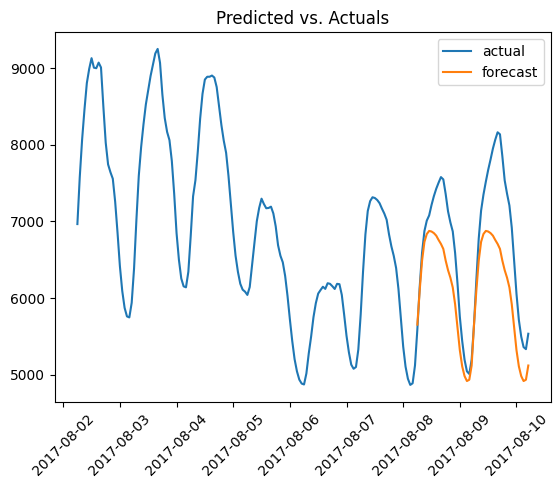

In [80]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(df[[target_column_name, "predicted"]])
plt.xticks(rotation=45)
plt.title(f"Predicted vs. Actuals")
plt.legend(["actual", "forecast"])
plt.show()

In [81]:
# Delete the batch endpoint and compute. Do not do it occasionally.
ml_client.batch_endpoints.begin_delete(name=batch_endpoint_name)
ml_client.compute.begin_delete(name=cluster_name)

Deleting batch endpoint energy-demand 

...........

Done (0m 55s)


## 6.3 Deployment
After we have tasted our model on the batch endpoint, we may want to deploy it as a service. Currently no code deployment using mlflow is not supported for forecasting tasks and we will use the model from AutoML V1. For this deployment we will use the same model and environment, we have tested on the endpoint.

In [82]:
# Creating a unique endpoint name with current datetime to avoid conflicts
import datetime
from azure.ai.ml.entities import (
    ManagedOnlineEndpoint,
    ManagedOnlineDeployment,
    CodeConfiguration,
    ProbeSettings,
)
from azure.ai.ml.constants import ModelType

online_endpoint_name = "energydata-" + datetime.datetime.now().strftime("%m%d%H%M%f")

# create an online endpoint
endpoint = ManagedOnlineEndpoint(
    name=online_endpoint_name,
    description="this is a sample online endpoint for mlflow model",
    auth_mode="key",
)

code_configuration = CodeConfiguration(
    code="artifact_downloads/outputs/", scoring_script="scoring_file_v_2_0_0.py"
)

Create a deployment.

In [83]:
deployment = ManagedOnlineDeployment(
    name="energy-managed-deploy",
    endpoint_name=online_endpoint_name,
    model=registered_model.id,
    environment=env,
    code_configuration=code_configuration,
    instance_type="Standard_DS2_V2",
    instance_count=1,
)
# deployment to take 100% traffic
endpoint.traffic = {"energy-managed-deploy": 100}
ml_client.begin_create_or_update(endpoint)

ManagedOnlineEndpoint({'public_network_access': 'Enabled', 'provisioning_state': 'Succeeded', 'scoring_uri': 'https://energydata-10062155057812.southcentralus.inference.ml.azure.com/score', 'swagger_uri': 'https://energydata-10062155057812.southcentralus.inference.ml.azure.com/swagger.json', 'name': 'energydata-10062155057812', 'description': 'this is a sample online endpoint for mlflow model', 'tags': {}, 'properties': {'azureml.onlineendpointid': '/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/resourcegroups/nirovins-southcentralus-rg/providers/microsoft.machinelearningservices/workspaces/nirovins-southcentralus-ws/onlineendpoints/energydata-10062155057812', 'AzureAsyncOperationUri': 'https://management.azure.com/subscriptions/381b38e9-9840-4719-a5a0-61d9585e1e91/providers/Microsoft.MachineLearningServices/locations/southcentralus/mfeOperationsStatus/oe:7e531619-13e1-48f5-849f-c0e50483676b:4feb1832-a91b-4cd5-9db8-1a15e54e3528?api-version=2022-02-01-preview'}, 'id': '/subscriptio

In [84]:
ml_client.online_deployments.begin_create_or_update(deployment)

Check: endpoint energydata-10062155057812 exists
Uploading outputs (5.17 MBs): 100%|######################################| 5173864/5173864 [00:10<00:00, 488267.80it/s]


data_collector is not a known attribute of class <class 'azure.ai.ml._restclient.v2022_02_01_preview.models._models_py3.ManagedOnlineDeployment'> and will be ignored
Creating/updating online deployment energy-managed-deploy 

..........................

ServiceRequestError: <urllib3.connection.HTTPSConnection object at 0x000002E8D302F5E0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed

Test the endpoint on small data sample. Big data sized can lead to timeouts.

In [ ]:
import pandas as pd

test_data = pd.read_csv("./data/test-mltable-folder/nyc_energy_test_clean.csv")

test_data = test_data.drop(target_column_name, axis=1)

test_data_json = test_data.to_json(orient="records", indent=4)
data = (
    '{ \
          "Inputs": {"data": '
    + test_data_json
    + '}, \
          "GlobalParameters": { "quantiles": [0.025, 0.975] } \
        }'
)

request_file_name = "sample-request-energy.json"

with open(request_file_name, "w") as request_file:
    request_file.write(data)

output = ml_client.online_endpoints.invoke(
    endpoint_name=online_endpoint_name,
    deployment_name="energy-managed-deploy",
    request_file=request_file_name,
)

In [ ]:
# Get the details for online endpoint
endpoint = ml_client.online_endpoints.get(name=online_endpoint_name)

# existing traffic details
print(endpoint.traffic)

# Get the scoring URI
print(endpoint.scoring_uri)

Send the request and deserialize the data.

In [ ]:
try:
    res_dict = json.loads(output)["Results"]
    y_fcst_all = pd.DataFrame(res_dict["index"])
    y_fcst_all[time_column_name] = pd.to_datetime(
        y_fcst_all[time_column_name], unit="ms"
    )
    y_fcst_all["forecast"] = res_dict["forecast"]
    y_fcst_all["prediction_interval"] = res_dict["prediction_interval"]
except:
    raise
    print(res_dict)

In [ ]:
y_fcst_all.head()

In [ ]:
# Delete the service. Do not do it occasionally.
ml_client.online_endpoints.begin_delete(name=batch_endpoint_name)

# Next Step: Load the best model and try predictions

Loading the models locally assume that you are running the notebook in an environment compatible with the model. The list of dependencies that is expected by the model is specified in the MLFlow model produced by AutoML (in the 'conda.yaml' file within the mlflow-model folder).

Since the AutoML model was trained remotelly in a different environment with different dependencies to your current local conda environment where you are running this notebook, if you want to load the model you have several options:

1. A recommended way to locally load the model in memory and try predictions is to create a new/clean conda environment with the dependencies specified in the conda.yml file within the MLFlow model's folder, then use MLFlow to load the model and call .predict() as explained in the notebook **mlflow-model-local-inference-test.ipynb** in this same folder.

2. You can install all the packages/dependencies specified in conda.yml into your current conda environment you used for using Azure ML SDK and AutoML. MLflow SDK also have a method to install the dependencies in the current environment. However, this option could have risks of package version conflicts depending on what's installed in your current environment.

3. You can also use: mlflow models serve -m 'xxxxxxx'

# Next Steps
You can see further examples of other AutoML tasks such as Image-Classification, Image-Object-Detection, NLP-Text-Classification, Time-Series-Forcasting, etc.